In [3]:
from env_hiv import HIVPatient
import torch
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from gymnasium.wrappers import TimeLimit
import matplotlib.pyplot as plt
#from RF_FQI_agent import RandomForestFQI
#from DQN_agent import DQN_AGENT
from DQNNetwork import DQNNetwork
import matplotlib.pyplot as plt

# Manipulate the environment

In [4]:
env = TimeLimit(
                env = HIVPatient(domain_randomization=False),
                max_episode_steps = 200
                )  

def collect_samples(env, horizon = 200, disable_tqdm=False, print_done_states=False):
    s, _ = env.reset()
    S = []
    A = []
    R = []
    S2 = []
    D = []
    for _ in tqdm(range(horizon), disable=disable_tqdm):
        a = env.action_space.sample()
        s2, r, done, trunc, _ = env.step(a)
        #dataset.append((s,a,r,s2,done,trunc))
        S.append(s)
        A.append(a)
        R.append(r)
        S2.append(s2)
        D.append(done)
        if done or trunc:
            s, _ = env.reset()
            if done and print_done_states:
                print("done!")
        else:
            s = s2
    S = np.array(S)
    A = np.array(A).reshape((-1,1))
    R = np.array(R)
    S2= np.array(S2)
    D = np.array(D)
    return S, A, R, S2, D

S, A, R, S2, D = collect_samples(env, horizon = 200, disable_tqdm=False, print_done_states=False)
print("nb of collected samples:", S.shape[0])
i = np.random.choice(S.shape[0])
print("sample", i, "\n  state:", S[i], "\n  action:", A[i], "\n  reward:", R[i], "\n  next state:", S2[i], "\n terminal?", D[i])

100%|██████████| 200/200 [00:03<00:00, 66.55it/s]

nb of collected samples: 200
sample 75 
  state: [4.09767128e+05 7.74586758e+02 6.91411441e+01 3.40481596e+01
 4.36711057e+03 7.32727909e+01] 
  action: [0] 
  reward: 72836.0798731271 
  next state: [3.19056211e+05 5.00000000e+04 1.00406699e+00 5.36377636e+01
 2.50000000e+05 6.69143955e+01] 
 terminal? False


In [9]:
observation, _ = env.reset()
env.step(2)

(array([1.99133864e+05, 1.21948890e+03, 3.80403636e+01, 3.31445905e+01,
        6.94253940e+03, 2.58476879e+01]),
 np.float64(7808.100000000002),
 False,
 False,
 {})

In [13]:
env.action_space.sample()
int(env.action_space.n)

4

In [17]:
env.action_space.n

np.int64(4)

In [6]:
SA = np.append(S,A,axis=1)
value = R.copy()

Q1 = RandomForestRegressor()
Q1.fit(SA,value)
print("training MSE:", np.mean((value-Q1.predict(SA))**2))

training MSE: 1953484.3193758638


In [7]:
T1 = 163573.0  # healthy type 1 cells concentration (cells per mL)
T1star = 11945.0  # infected type 1 cells concentration (cells per mL)
T2 = 5.0  # healthy type 2 cells concentration (cells per mL)
T2star = 46.0  # infected type 2 cells concentration (cells per mL)
V = 63919.0  # free virus (copies per mL)
E = 24.0  # immune effector cells concentration (cells per mL)
s = np.array([T1, T1star, T2, T2star, V, E])
T1Upper = 1e6
T1starUpper = 5e4
T2Upper = 3200.0
T2starUpper = 80.0
VUpper = 2.5e5
EUpper = 353200.0
upper = np.array(
    [
        T1Upper,
        T1starUpper,
        T2Upper,
        T2starUpper,
        VUpper,
        EUpper,
    ]
)

T1Lower = 0.0
T1starLower = 0.0
T2Lower = 0.0
T2starLower = 0.0
VLower = 0.0
ELower = 0.0
lower = np.array(
    [
        T1Lower,
        T1starLower,
        T2Lower,
        T2starLower,
        VLower,
        ELower,
    ]
)

np.clip(s, lower, upper, out=s)

array([1.63573e+05, 1.19450e+04, 5.00000e+00, 4.60000e+01, 6.39190e+04,
       2.40000e+01])

# Try Random Forest based FQI algorithm 

100%|██████████| 10/10 [00:00<00:00, 18.14it/s]


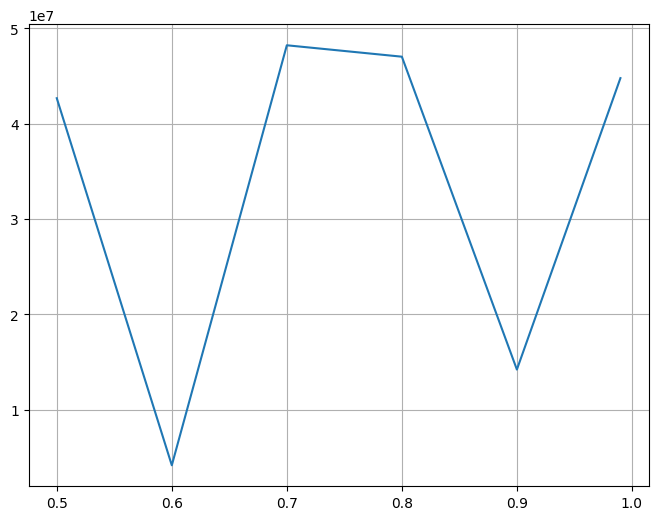

In [2]:
env = TimeLimit(
                env = HIVPatient(domain_randomization=False),
                max_episode_steps = 200
                )  
GAMMAS = [.5, .6, .7, .8, .9, .99]
rewards = []
for gamma in GAMMAS:
    rf_fqi = RandomForestFQI(env = env, gamma = .9)
    rf_fqi.collect_samples(horizon = 200)
    rf_fqi.train()
    mean_reward = rf_fqi.evaluate()
    rewards.append(mean_reward)

plt.figure(figsize = (8, 6))
plt.plot(GAMMAS, rewards)
plt.grid()
plt.show()


In [3]:
rf_fqi = RandomForestFQI(env = env, gamma = .9)
rf_fqi.collect_samples(horizon = 200)
rf_fqi.train()
mean_reward = rf_fqi.evaluate()
print("mean reward:", mean_reward)

100%|██████████| 10/10 [00:00<00:00, 18.89it/s]


mean reward: 1898020693.0617626


# DQN

In [11]:
env = TimeLimit(
                env = HIVPatient(domain_randomization=False),
                max_episode_steps = 200
                )  
device = torch.device('cpu')
model = DQNNetwork(state_dim = env.observation_space.shape[0], nb_neurons = 256, n_action = 4).to(device)
model.load_state_dict(torch.load("/Users/augustincablant/Documents/GitHub/assignment-AugustinCablant/src/models/DQN/config1.pt", map_location = device))

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_36034/291441907.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/augus

<All keys matched successfully>

In [17]:
obs, _ = env.reset()
model(torch.Tensor(obs).unsqueeze(0).to(device))

tensor([[2509221.2500, 2224818.7500, 2548098.5000, 1657295.2500]],
       grad_fn=<AddmmBackward0>)

In [2]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import torch
from copy import deepcopy
import random 
from DQNNetwork import DQNNetwork
from DQN_agent import DQN_AGENT
from gymnasium.wrappers import TimeLimit
from env_hiv import HIVPatient
from evaluate import evaluate_HIV  

scores = []
for gradient_steps in tqdm([1, 3, 5, 10]):
    print(tqdm.write("gradient_steps: {}".format(gradient_steps)))
    configg = {
        'learning_rate': 0.001,
        'gamma': .9,
        'buffer_size': 1000000,
        'epsilon_min': 0.01,
        'epsilon_max': 0.01,
        'epsilon_decay_period': 1000,
        'epsilon_delay_decay': 20,
        'batch_size': 1000,
        'gradient_steps': gradient_steps,
        'update_target_strategy': 'replace', # or 'ema'
        'update_target_freq': 50,
        'update_target_tau': 0.005,
        'criterion': torch.nn.SmoothL1Loss(),
        'monitoring_nb_trials': 0,
        'nb_neurons': 256
        }
    agent = DQN_AGENT(configg)
    agent.train(path = "empty", max_episode = 200, save = False)
    score_agent: float = evaluate_HIV(agent = agent, nb_episode = 1)
    scores.append(score_agent)
    print("score:", score_agent, "for gradient_steps:", gradient_steps)

plt.figure(figsize = (8, 6))
plt.plot([1, 3, 5, 10], scores)
plt.grid()
plt.show()

Episode   1, epsilon   0.01, batch size   200, episode return 3208373.2
Episode   2, epsilon   0.01, batch size   400, episode return 5290935.7
Episode   3, epsilon   0.01, batch size   600, episode return 3328360.2
Episode   4, epsilon   0.01, batch size   800, episode return 3208373.2
Episode   5, epsilon   0.01, batch size  1000, episode return 3208373.2
Episode   6, epsilon   0.01, batch size  1200, episode return 11922097.2
Episode   7, epsilon   0.01, batch size  1400, episode return 12743214.6
Episode   8, epsilon   0.01, batch size  1600, episode return 7879587.6
Episode   9, epsilon   0.01, batch size  1800, episode return 14500188.8
Episode  10, epsilon   0.01, batch size  2000, episode return 10695255.7
Episode  11, epsilon   0.01, batch size  2200, episode return 14544787.6
Episode  12, epsilon   0.01, batch size  2400, episode return 17556638.0
Episode  13, epsilon   0.01, batch size  2600, episode return 9075808.6
Episode  14, epsilon   0.01, batch size  2800, episode ret

  0%|          | 0/4 [00:00<?, ?it/s]

gradient_steps: 1
None
Episode   1, epsilon   0.01, batch size   200, episode return 3465034.5
Episode   2, epsilon   0.01, batch size   400, episode return 3432807.7
Episode   3, epsilon   0.01, batch size   600, episode return 3449936.3
Episode   4, epsilon   0.01, batch size   800, episode return 3449909.0
Episode   5, epsilon   0.01, batch size  1000, episode return 3432807.7
Episode   6, epsilon   0.01, batch size  1200, episode return 13735684.0
Episode   7, epsilon   0.01, batch size  1400, episode return 4518657.7
Episode   8, epsilon   0.01, batch size  1600, episode return 6451500.9
Episode   9, epsilon   0.01, batch size  1800, episode return 4503996.1
Episode  10, epsilon   0.01, batch size  2000, episode return 4718002.2
Episode  11, epsilon   0.01, batch size  2200, episode return 6554203.9
Episode  12, epsilon   0.01, batch size  2400, episode return 4509909.2
Episode  13, epsilon   0.01, batch size  2600, episode return 15721942.9
Episode  14, epsilon   0.01, batch size

 25%|██▌       | 1/4 [19:01<57:03, 1141.01s/it]

score: 10824130312.797333 for gradient_steps: 1
gradient_steps: 3
None
Episode   1, epsilon   0.01, batch size   200, episode return 3432807.7
Episode   2, epsilon   0.01, batch size   400, episode return 3457268.7
Episode   3, epsilon   0.01, batch size   600, episode return 3457268.4
Episode   4, epsilon   0.01, batch size   800, episode return 3446960.1
Episode   5, epsilon   0.01, batch size  1000, episode return 3447201.3
Episode   6, epsilon   0.01, batch size  1200, episode return 5292294.5
Episode   7, epsilon   0.01, batch size  1400, episode return 13307372.2
Episode   8, epsilon   0.01, batch size  1600, episode return 13791330.7
Episode   9, epsilon   0.01, batch size  1800, episode return 18800007.9
Episode  10, epsilon   0.01, batch size  2000, episode return 21775671.2
Episode  11, epsilon   0.01, batch size  2200, episode return 17996320.6
Episode  12, epsilon   0.01, batch size  2400, episode return 3450943.6
Episode  13, epsilon   0.01, batch size  2600, episode retur

 50%|█████     | 2/4 [44:27<45:36, 1368.00s/it]

score: 40229110189.44091 for gradient_steps: 3
gradient_steps: 5
None
Episode   1, epsilon   0.01, batch size   200, episode return 9574612.6
Episode   2, epsilon   0.01, batch size   400, episode return 6773782.7
Episode   3, epsilon   0.01, batch size   600, episode return 6767376.8
Episode   4, epsilon   0.01, batch size   800, episode return 7104328.9
Episode   5, epsilon   0.01, batch size  1000, episode return 7205137.1
Episode   6, epsilon   0.01, batch size  1200, episode return 7891602.7
Episode   7, epsilon   0.01, batch size  1400, episode return 5504400.5
Episode   8, epsilon   0.01, batch size  1600, episode return 8994164.4
Episode   9, epsilon   0.01, batch size  1800, episode return 18628814.1
Episode  10, epsilon   0.01, batch size  2000, episode return 12896093.5
Episode  11, epsilon   0.01, batch size  2200, episode return 14692389.5
Episode  12, epsilon   0.01, batch size  2400, episode return 18032652.0
Episode  13, epsilon   0.01, batch size  2600, episode return 

 75%|███████▌  | 3/4 [1:17:19<27:23, 1643.56s/it]

score: 39579674947.208405 for gradient_steps: 5
gradient_steps: 10
None
Episode   1, epsilon   0.01, batch size   200, episode return 3652153.3
Episode   2, epsilon   0.01, batch size   400, episode return 3652153.3
Episode   3, epsilon   0.01, batch size   600, episode return 3697713.5
Episode   4, epsilon   0.01, batch size   800, episode return 3676040.7
Episode   5, epsilon   0.01, batch size  1000, episode return 3698720.8
Episode   6, epsilon   0.01, batch size  1200, episode return 4711332.0
Episode   7, epsilon   0.01, batch size  1400, episode return 3465829.3
Episode   8, epsilon   0.01, batch size  1600, episode return 4572929.6
Episode   9, epsilon   0.01, batch size  1800, episode return 6220916.8
Episode  10, epsilon   0.01, batch size  2000, episode return 3211559.9
Episode  11, epsilon   0.01, batch size  2200, episode return 4096939.7
Episode  12, epsilon   0.01, batch size  2400, episode return 4747821.7
Episode  13, epsilon   0.01, batch size  2600, episode return 67

100%|██████████| 4/4 [2:05:21<00:00, 1880.38s/it]

score: 41046767560.752625 for gradient_steps: 10


NameError: name 'plt' is not defined

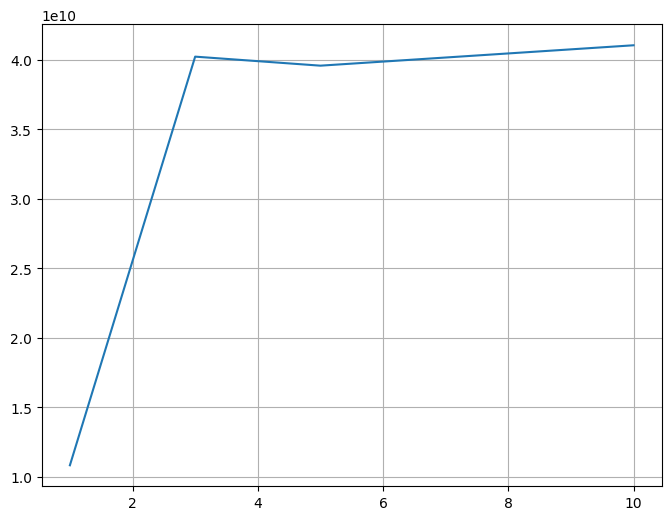

In [4]:
plt.figure(figsize = (8, 6))
plt.plot([1, 3, 5, 10], scores)
plt.grid()
plt.show()

best gradient_step : 10 with score (41046767560.752625)

In [12]:
scores = []
for gradient_steps in tqdm([15, 20, 25]):
    print(tqdm.write("gradient_steps: {}".format(gradient_steps)))
    configg = {
        'learning_rate': 0.001,
        'gamma': .8,
        'buffer_size': 1000000,
        'epsilon_min': 0.01,
        'epsilon_max': 0.01,
        'epsilon_decay_period': 1000,
        'epsilon_delay_decay': 20,
        'batch_size': 1000,
        'gradient_steps': gradient_steps,
        'update_target_strategy': 'replace', # or 'ema'
        'update_target_freq': 50,
        'update_target_tau': 0.005,
        'criterion': torch.nn.SmoothL1Loss(),
        'monitoring_nb_trials': 0,
        'nb_neurons': 256
        }
    agent = DQN_AGENT(configg)
    agent.train(path = "empty", max_episode = 1000, save = False)
    score_agent: float = evaluate_HIV(agent = agent, nb_episode = 1)
    scores.append(score_agent)
    print("score:", score_agent, "for gradient_steps:", gradient_steps)

plt.figure(figsize = (8, 6))
plt.plot([15, 20, 25], scores)
plt.grid()
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

gradient_steps: 15
None
Episode   1, epsilon   0.01, batch size   200, episode return 22965632.1
Episode   2, epsilon   0.01, batch size   400, episode return 26381103.9
Episode   3, epsilon   0.01, batch size   600, episode return 24837569.3
Episode   4, epsilon   0.01, batch size   800, episode return 26553089.1
Episode   5, epsilon   0.01, batch size  1000, episode return 26662342.5
Episode   6, epsilon   0.01, batch size  1200, episode return 12573791.6
Episode   7, epsilon   0.01, batch size  1400, episode return 11455671.9
Episode   8, epsilon   0.01, batch size  1600, episode return 10491095.1
Episode   9, epsilon   0.01, batch size  1800, episode return 6361859.8
Episode  10, epsilon   0.01, batch size  2000, episode return 10098044.8
Episode  11, epsilon   0.01, batch size  2200, episode return 53784997.7
Episode  12, epsilon   0.01, batch size  2400, episode return 51782705.1
Episode  13, epsilon   0.01, batch size  2600, episode return 83178980.0
Episode  14, epsilon   0.01,

  0%|          | 0/3 [16:29<?, ?it/s]


KeyboardInterrupt: 

  0%|          | 0/4 [00:00<?, ?it/s]

Episode   1, epsilon   0.01, batch size   200, episode return 3481717.7
Episode   2, epsilon   0.01, batch size   400, episode return 3432807.7
Episode   3, epsilon   0.01, batch size   600, episode return 3432807.7
Episode   4, epsilon   0.01, batch size   800, episode return 3432807.7
Episode   5, epsilon   0.01, batch size  1000, episode return 3496358.8
Episode   6, epsilon   0.01, batch size  1200, episode return 4182937.1
Episode   7, epsilon   0.01, batch size  1400, episode return 7877923.6
Episode   8, epsilon   0.01, batch size  1600, episode return 33441757.7
Episode   9, epsilon   0.01, batch size  1800, episode return 31754858.3
Episode  10, epsilon   0.01, batch size  2000, episode return 33203634.6
Episode  11, epsilon   0.01, batch size  2200, episode return 42996249.3
Episode  12, epsilon   0.01, batch size  2400, episode return 53183080.2
Episode  13, epsilon   0.01, batch size  2600, episode return 75033940.5
Episode  14, epsilon   0.01, batch size  2800, episode ret

 25%|██▌       | 1/4 [50:21<2:31:04, 3021.52s/it]

score: 38090528072.80494 for gamma: 0.7
Episode   1, epsilon   0.01, batch size   200, episode return 8149033.2
Episode   2, epsilon   0.01, batch size   400, episode return 6770463.8
Episode   3, epsilon   0.01, batch size   600, episode return 10183972.6
Episode   4, epsilon   0.01, batch size   800, episode return 7438085.9
Episode   5, epsilon   0.01, batch size  1000, episode return 9903443.6
Episode   6, epsilon   0.01, batch size  1200, episode return 3986563.7
Episode   7, epsilon   0.01, batch size  1400, episode return 3384654.4
Episode   8, epsilon   0.01, batch size  1600, episode return 4013988.5
Episode   9, epsilon   0.01, batch size  1800, episode return 5209964.4
Episode  10, epsilon   0.01, batch size  2000, episode return 54283501.2
Episode  11, epsilon   0.01, batch size  2200, episode return 64893787.0
Episode  12, epsilon   0.01, batch size  2400, episode return 97027002.2
Episode  13, epsilon   0.01, batch size  2600, episode return 113762932.7
Episode  14, epsil

 50%|█████     | 2/4 [1:38:43<1:38:21, 2950.96s/it]

score: 41392774716.88369 for gamma: 0.8
Episode   1, epsilon   0.01, batch size   200, episode return 3542957.6
Episode   2, epsilon   0.01, batch size   400, episode return 3191743.6
Episode   3, epsilon   0.01, batch size   600, episode return 3191743.6
Episode   4, epsilon   0.01, batch size   800, episode return 4698189.4
Episode   5, epsilon   0.01, batch size  1000, episode return 5736767.7
Episode   6, epsilon   0.01, batch size  1200, episode return 2938365.8
Episode   7, epsilon   0.01, batch size  1400, episode return 7610969.5
Episode   8, epsilon   0.01, batch size  1600, episode return 7322119.1
Episode   9, epsilon   0.01, batch size  1800, episode return 22999720.4
Episode  10, epsilon   0.01, batch size  2000, episode return 11865783.0
Episode  11, epsilon   0.01, batch size  2200, episode return 17364956.2
Episode  12, epsilon   0.01, batch size  2400, episode return 19472483.1
Episode  13, epsilon   0.01, batch size  2600, episode return 13314114.5
Episode  14, epsilo

 75%|███████▌  | 3/4 [2:28:24<49:24, 2964.91s/it]  

score: 39986729330.91646 for gamma: 0.9
Episode   1, epsilon   0.01, batch size   200, episode return 3812038.3
Episode   2, epsilon   0.01, batch size   400, episode return 3684182.9
Episode   3, epsilon   0.01, batch size   600, episode return 3672899.4
Episode   4, epsilon   0.01, batch size   800, episode return 3725254.6
Episode   5, epsilon   0.01, batch size  1000, episode return 3672857.5
Episode   6, epsilon   0.01, batch size  1200, episode return 21091039.6
Episode   7, epsilon   0.01, batch size  1400, episode return 16363463.7
Episode   8, epsilon   0.01, batch size  1600, episode return 54718523.9
Episode   9, epsilon   0.01, batch size  1800, episode return 29351896.0
Episode  10, epsilon   0.01, batch size  2000, episode return 22139114.0
Episode  11, epsilon   0.01, batch size  2200, episode return 31550199.8
Episode  12, epsilon   0.01, batch size  2400, episode return 24677369.4
Episode  13, epsilon   0.01, batch size  2600, episode return 23776456.8
Episode  14, eps

100%|██████████| 4/4 [3:18:44<00:00, 2981.19s/it]

score: 29593798.29765492 for gamma: 0.99


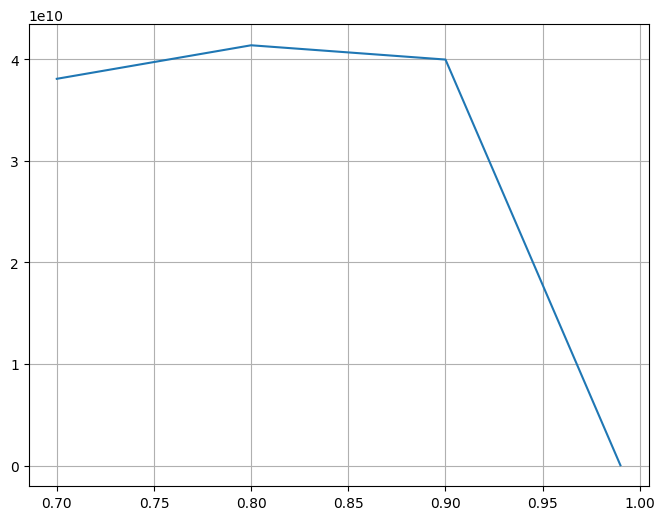

In [10]:
scores2 = []
for gamma in tqdm([.7, .8, .9, .99]):
    configg = {
        'learning_rate': 0.001,
        'gamma': gamma,
        'buffer_size': 1000000,
        'epsilon_min': 0.01,
        'epsilon_max': 0.01,
        'epsilon_decay_period': 1000,
        'epsilon_delay_decay': 20,
        'batch_size': 1000,
        'gradient_steps': 10,
        'update_target_strategy': 'replace', # or 'ema'
        'update_target_freq': 50,
        'update_target_tau': 0.005,
        'criterion': torch.nn.SmoothL1Loss(),
        'monitoring_nb_trials': 0,
        'nb_neurons': 256
        }
    agent = DQN_AGENT(configg)
    agent.train(path = "empty", max_episode = 200, save = False)
    score_agent: float = evaluate_HIV(agent = agent, nb_episode = 1)
    scores2.append(score_agent)
    print("score:", score_agent, "for gamma:", gamma)

plt.figure(figsize = (8, 6))
plt.plot([.7, .8, .9, .99], scores2)
plt.grid()
plt.show()

41392774716.88369 for gamma = 0.8
39986729330.91646 for gamma: 0.9

In [13]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
from joblib import dump, load
from env_hiv import HIVPatient
from evaluate import evaluate_HIV  
from gymnasium.wrappers import TimeLimit

class RandomForestFQI():
    def __init__(self, env, gamma = .7, horizon = 1000):
        self.states = gym.spaces.Discrete(4)
        self.actions = [np.array(pair) for pair in [[0.0, 0.0], [0.0, 0.3], [0.7, 0.0], [0.7, 0.3]]]
        self.nb_actions = len(self.actions)
        self.env = env
        self.gamma = gamma
        self.rf_model = None
        self.horizon = horizon

    def collect_samples(self, disable_tqdm = False, print_done_states = False):
        s, _ = self.env.reset()
        dataset = []
        S = []
        A = []
        R = []
        S2 = []
        D = []
        for _ in tqdm(range(self.horizon), disable = disable_tqdm):
            a = self.env.action_space.sample()
            s2, r, done, trunc, _ = self.env.step(a)
            dataset.append((s, a, r, s2, done, trunc))
            S.append(s)
            A.append(a)
            R.append(r)
            S2.append(s2)
            D.append(done)
            if done or trunc:
                s, _ = self.env.reset()
                if done and print_done_states:
                    print("done!")
            else:
                s = s2
        self.S = np.array(S)
        self.A = np.array(A).reshape((-1, 1))
        self.R = np.array(R)
        self.S2 = np.array(S2)
        self.D = np.array(D)

    
    def train(self, iterations = 10, disable_tqdm = False):
        self.collect_samples()
        nb_samples = self.S.shape[0]
        Qfunctions = []
        SA = np.append(self.S,
                            self.A,
                            axis = 1)
        for iter in tqdm(range(iterations), disable=disable_tqdm):
            if iter==0:
                value = self.R.copy()
            else:
                Q2 = np.zeros((nb_samples, self.nb_actions))
                for a2 in range(self.nb_actions):
                    A2 = a2 * np.ones((nb_samples, 1))
                    S2A2 = np.append(self.S2, A2,axis=1)
                    Q2[:,a2] = Qfunctions[-1].predict(S2A2)
                max_Q2 = np.max(Q2,axis=1)
                value = self.R + self.gamma * (1 - self.D) * max_Q2
            Q = RandomForestRegressor()
            Q.fit(SA, value)
            Qfunctions.append(Q)
        self.rf_model = Qfunctions[-1]

    def greedy_action(self, state):
        Qsa = []
        for a in range(self.nb_actions):
            sa = np.append(state, a).reshape(1, -1)
            Qsa.append(self.rf_model.predict(sa))
        print(Qsa)
        return np.argmax(Qsa)
    
    def evaluate(self):
        score = evaluate_HIV(agent = self, nb_episode = 1)
        print("score:", score)
    
    def act(self, observation, use_random = False):
        if use_random:
            return self.env.action_space.sample()
        else:
            self.greedy_action(observation)

    def save(self, path):
        dump(self.Qfunctions, path)
        data_to_save = {
            'Qfunctions': self.Qfunctions[-1]}
        dump(data_to_save, path, compress = 9)

    def load(self, path):
        self.Qfunctions = load(path)
        loaded_data = load(path)
        self.Qfunctions = loaded_data['Qfunctions']
    
env = TimeLimit(
                env = HIVPatient(domain_randomization=False),
                max_episode_steps = 200
                )  
agent = RandomForestFQI(env)
agent.train()

100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


In [14]:
rewards: list[float] = []

obs, info = env.reset()
done = False
truncated = False
episode_reward = 0
while not done and not truncated:
    action = agent.act(obs)
    print(obs)
    print(action)
    obs, reward, done, truncated, _ = env.step(action)
    episode_reward += reward
rewards.append(episode_reward)
print(np.mean(rewards))

ValueError: Expected 2D array, got 1D array instead:
array=[1.63573e+05 1.19450e+04 5.00000e+00 4.60000e+01 6.39190e+04 2.40000e+01
 0.00000e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [16]:
s, _ = env.reset()
dataset = []
S = []
A = []
R = []
S2 = []
D = []
for _ in tqdm(range(1000)):
    a = env.action_space.sample()
    s2, r, done, trunc, _ = env.step(a)
    dataset.append((s, a, r, s2, done, trunc))
    S.append(s)
    A.append(a)
    R.append(r)
    S2.append(s2)
    D.append(done)
    if done or trunc:
        s, _ = env.reset()
        if done:
            print("done!")
    else:
        s = s2
S = np.array(S)
A = np.array(A).reshape((-1, 1))
R = np.array(R)
S2 = np.array(S2)
D = np.array(D)

100%|██████████| 1000/1000 [00:13<00:00, 71.51it/s]


In [18]:
S.shape

(1000, 6)

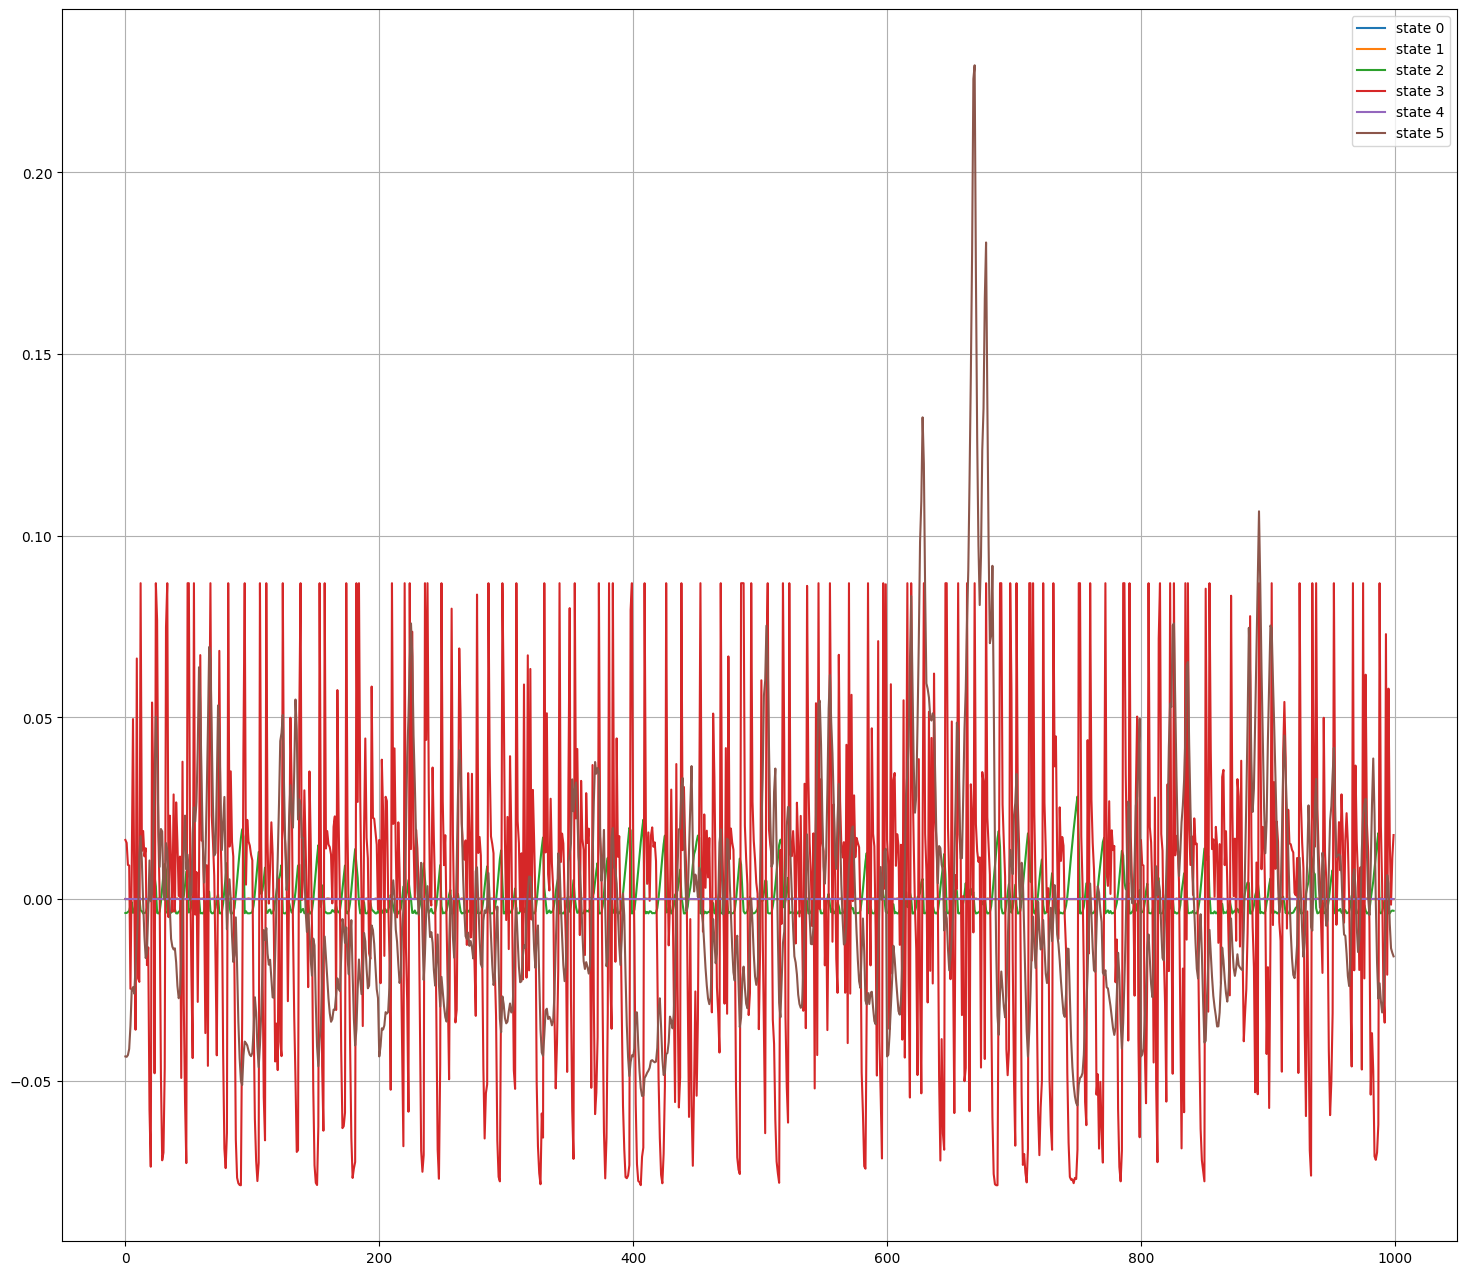

In [21]:
plt.figure(figsize = (18, 16))
for i in range(S.shape[1]):
    plt.subplot(3, 2, i+1)
    plt.plot(S[:, i], label = "state {}".format(i))
    plt.xlabel("time")
    plt.ylabel("state value")
plt.legend()
plt.grid()
plt.show()

In [5]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
from joblib import dump, load
from env_hiv import HIVPatient
from evaluate import evaluate_HIV  
from gymnasium.wrappers import TimeLimit

env = TimeLimit(
                env = HIVPatient(domain_randomization = False),
                max_episode_steps = 200
                )  
gamma = .7 
horizon = 1000
states = env.observation_space.shape[0]
n_action = env.action_space.n 
nb_actions = int(env.action_space.n)
rf_model = None
horizon = horizon

def collect_samples(disable_tqdm = False, print_done_states = False):
    s, _ = env.reset()
    dataset = []
    S = []
    A = []
    R = []
    S2 = []
    D = []
    for _ in tqdm(range(horizon), disable = disable_tqdm):
        a = env.action_space.sample()
        s2, r, done, trunc, _ = env.step(a)
        dataset.append((s, a, r, s2, done, trunc))
        S.append(s)
        A.append(a)
        R.append(r)
        S2.append(s2)
        D.append(done)
        if done or trunc:
            s, _ = env.reset()
            if done and print_done_states:
                print("done!")
        else:
            s = s2
    S = np.array(S)
    A = np.array(A).reshape((-1, 1))
    R = np.array(R)
    S2 = np.array(S2)
    D = np.array(D)
    return S, A, R, S2, D

In [6]:
S, A, R, S2, D = collect_samples(disable_tqdm = False, print_done_states = False)

100%|██████████| 1000/1000 [00:14<00:00, 71.00it/s]


In [8]:
def greedy_action(state):
        Qsa = []
        for a in range(nb_actions):
            sa = np.append(state, a).reshape(1, -1)
            Qsa.append(rf_model.predict(sa))
        return np.argmax(Qsa)
    
    
def act(observation, use_random = False):
    if use_random:
        return env.action_space.sample()
    else:
        greedy_action(observation)

def train(iterations = 10, disable_tqdm = False):
        S, A, R, S2, D = collect_samples(disable_tqdm = False, print_done_states = False)
        nb_samples = S.shape[0]
        Qfunctions = []
        SA = np.append(S,
                        A,
                        axis = 1)
        for iter in tqdm(range(iterations), disable=disable_tqdm):
            if iter==0:
                value = R.copy()
            else:
                Q2 = np.zeros((nb_samples, nb_actions))
                for a2 in range(nb_actions):
                    A2 = a2 * np.ones((nb_samples, 1))
                    S2A2 = np.append(S2, A2,axis=1)
                    Q2[:,a2] = Qfunctions[-1].predict(S2A2)
                max_Q2 = np.max(Q2,axis=1)
                value = R + gamma * (1 - D) * max_Q2
            Q = RandomForestRegressor()
            Q.fit(SA, value)
            Qfunctions.append(Q)
        rf_model = Qfunctions[-1]
        return rf_model



env = TimeLimit(
                env = HIVPatient(domain_randomization=False),
                max_episode_steps = 200
                )  

rf_model = train()

100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


In [12]:
rewards: list[float] = []
for _ in range(10):
    obs, info = env.reset()
    print(obs)
    done = False
    truncated = False
    episode_reward = 0
    while not done and not truncated:
        action = act(obs)
        print(action)
        obs, reward, done, truncated, _ = env.step(action)
        episode_reward += reward
    rewards.append(episode_reward)
print(np.mean(rewards))

[1.63573e+05 1.19450e+04 5.00000e+00 4.60000e+01 6.39190e+04 2.40000e+01]
None


TypeError: list indices must be integers or slices, not NoneType